In [8]:
pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
# we will be using various libraries like os for taking the input,etc
# I have used some libraries like seaborn, wordcloud, matplotlib for data visualization so
# you can skip them if you don't understand 

import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

# re is used for cleaning the dataset 

import re


import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

# callbacks are important here as sometimes you get the best accuracy earlies and then it 
# goes down so as to stop the training there you need to use them


from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Conv1D,LSTM,GRU,BatchNormalization,Flatten,Dense


# Data Preprocessing

In [10]:
df= pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


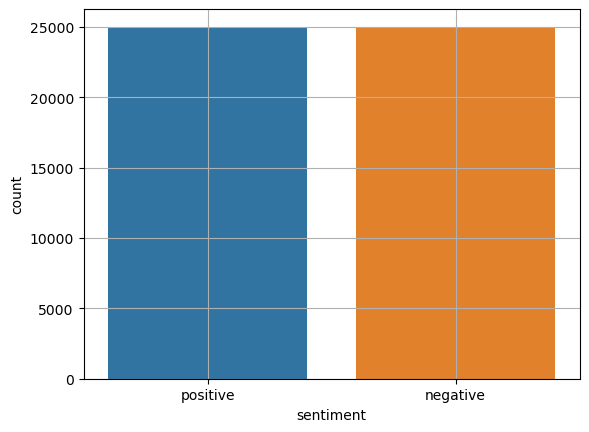

In [12]:
sns.countplot(x=df['sentiment'])
plt.grid()

In [13]:
sentences=df['review']
le=LabelEncoder()
df['sentiment']= le.fit_transform(df['sentiment'])

(-0.5, 799.5, 799.5, -0.5)

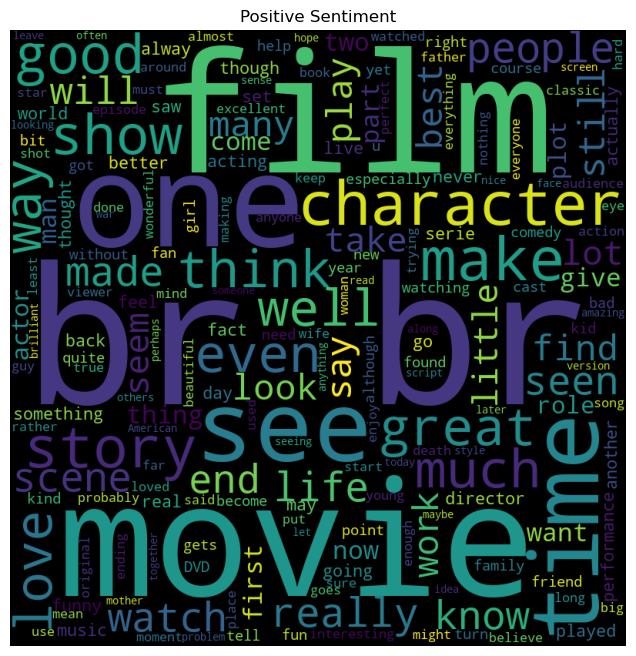

In [14]:
stopwords = set(STOPWORDS) 

pos=' '.join(map(str,sentences[df['sentiment']==1]))
neg=' '.join(map(str,sentences[df['sentiment']==0]))
  
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(pos) 

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Positive Sentiment')
plt.axis('off')

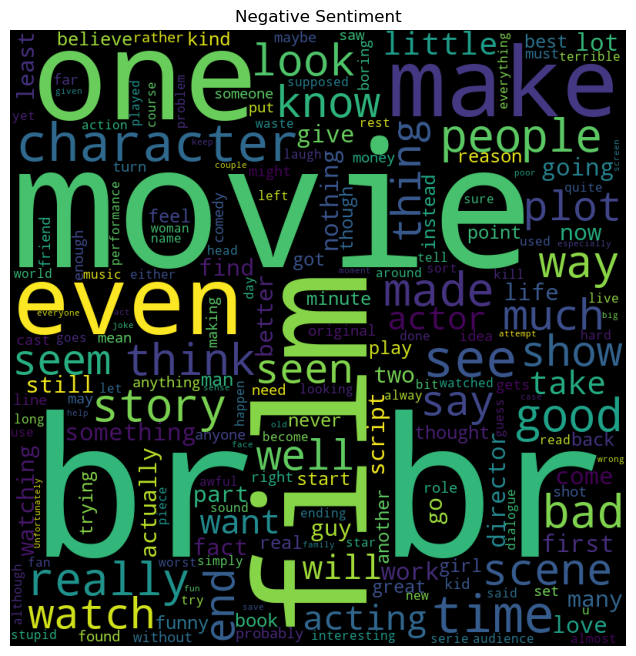

In [15]:
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(neg) 

plt.imshow(wordcloud2)
plt.title('Negative Sentiment')
plt.axis('off')

plt.show() 

In [16]:
labels=to_categorical(df['sentiment'],num_classes=2)
X_train,X_test,Y_train,Y_test = train_test_split(df['review'],labels,test_size=0.1,random_state=10)

# Data Cleaning

In [17]:
glove_embeddings= np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl',
                          allow_pickle=True)

In [18]:
def vocab_build(review):
    
    comments = review.apply(lambda s: s.split()).values
    vocab={}
    
    for comment in comments:
        for word in comment:
            try:
                vocab[word]+=1
                
            except KeyError:
                vocab[word]=1
    return vocab

In [19]:
def embedding_coverage(review,embeddings):
    
    vocab=vocab_build(review)
    
    covered={}
    word_count={}
    oov={}
    covered_num=0
    oov_num=0
    
    for word in vocab:
        try:
            covered[word]=embeddings[word]
            covered_num+=vocab[word]
            word_count[word]=vocab[word]
        except:
            oov[word]=vocab[word]
            oov_num+=oov[word]
    
    vocab_coverage=len(covered)/len(vocab)*100
    text_coverage = covered_num/(covered_num+oov_num)*100
    
    sorted_oov=sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    sorted_word_count=sorted(word_count.items(), key=operator.itemgetter(1))[::-1]
    
    return sorted_word_count,sorted_oov,vocab_coverage,text_coverage
        

In [20]:
train_covered,train_oov,train_vocab_coverage,train_text_coverage=embedding_coverage(X_train,glove_embeddings)
test_covered,test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(X_test,glove_embeddings)

print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in testing set")

Glove embeddings cover 26.74% of vocabulary and 87.62% text in training set
Glove embeddings cover 42.72% of vocabulary and 87.73% text in testing set


In [21]:
train_oov[:10]

[('/><br', 90971),
 ('/>The', 12949),
 ('film,', 7318),
 ('movie,', 7167),
 ('/>I', 6565),
 ("isn't", 5241),
 ('"The', 4379),
 ("he's", 3981),
 ('/>This', 3969),
 ("wasn't", 3788)]

In [22]:
def clean_sentences(line):
    
    line=re.sub('<.*?>','',line) # removing html tags
    
    #removing contractions
    line=re.sub("isn't",'is not',line)
    line=re.sub("he's",'he is',line)
    line=re.sub("wasn't",'was not',line)
    line=re.sub("there's",'there is',line)
    line=re.sub("couldn't",'could not',line)
    line=re.sub("won't",'will not',line)
    line=re.sub("they're",'they are',line)
    line=re.sub("she's",'she is',line)
    line=re.sub("There's",'there is',line)
    line=re.sub("wouldn't",'would not',line)
    line=re.sub("haven't",'have not',line)
    line=re.sub("That's",'That is',line)
    line=re.sub("you've",'you have',line)
    line=re.sub("He's",'He is',line)
    line=re.sub("what's",'what is',line)
    line=re.sub("weren't",'were not',line)
    line=re.sub("we're",'we are',line)
    line=re.sub("hasn't",'has not',line)
    line=re.sub("you'd",'you would',line)
    line=re.sub("shouldn't",'should not',line)
    line=re.sub("let's",'let us',line)
    line=re.sub("they've",'they have',line)
    line=re.sub("You'll",'You will',line)
    line=re.sub("i'm",'i am',line)
    line=re.sub("we've",'we have',line)
    line=re.sub("it's",'it is',line)
    line=re.sub("don't",'do not',line)
    line=re.sub("that´s",'that is',line)
    line=re.sub("I´m",'I am',line)
    line=re.sub("it’s",'it is',line)
    line=re.sub("she´s",'she is',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('I’m','I am',line)
    line=re.sub('I’d','I did',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('there’s','there is',line)
    
    #special characters and emojis
    line=re.sub('\x91The','The',line)
    line=re.sub('\x97','',line)
    line=re.sub('\x84The','The',line)
    line=re.sub('\uf0b7','',line)
    line=re.sub('¡¨','',line)
    line=re.sub('\x95','',line)
    line=re.sub('\x8ei\x9eek','',line)
    line=re.sub('\xad','',line)
    line=re.sub('\x84bubble','bubble',line)
    
    # remove concated words
    line=re.sub('trivialBoring','trivial Boring',line)
    line=re.sub('Justforkix','Just for kix',line)
    line=re.sub('Nightbeast','Night beast',line)
    line=re.sub('DEATHTRAP','Death Trap',line)
    line=re.sub('CitizenX','Citizen X',line)
    line=re.sub('10Rated','10 Rated',line)
    line=re.sub('_The','_ The',line)
    line=re.sub('1Sound','1 Sound',line)
    line=re.sub('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah','blah blah',line)
    line=re.sub('ResidentHazard','Resident Hazard',line)
    line=re.sub('iameracing','i am racing',line)
    line=re.sub('BLACKSNAKE','Black Snake',line)
    line=re.sub('DEATHSTALKER','Death Stalker',line)
    line=re.sub('_is_','is',line)
    line=re.sub('10Fans','10 Fans',line)
    line=re.sub('Yellowcoat','Yellow coat',line)
    line=re.sub('Spiderbabe','Spider babe',line)
    line=re.sub('Frightworld','Fright world',line)
    
    #removing punctuations
    
    punctuations = '@#!~?+&*[]-%._-:/£();$=><|{}^' + '''"“´”'`'''
    for p in punctuations:
        line = line.replace(p, f' {p} ')
        
    line=re.sub(',',' , ',line)
        
    # ... and ..
    line = line.replace('...', ' ... ')
    
    if '...' not in line:
        line = line.replace('..', ' ... ')
        
    return line
    

In [23]:
X_train=X_train.apply(lambda s: clean_sentences(s))
X_test=X_test.apply(lambda s: clean_sentences(s))

train_covered,train_oov,train_vocab_coverage,train_text_coverage=embedding_coverage(X_train,glove_embeddings)
print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")

test_covered,test_oov,test_vocab_coverage,test_text_coverage=embedding_coverage(X_test,glove_embeddings)
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in training set")

Glove embeddings cover 86.92% of vocabulary and 99.82% text in training set
Glove embeddings cover 95.5% of vocabulary and 99.82% text in training set


In [24]:
punctuations = '@#!~?+&*[]-%._-:/£();$=><|{},^' + '''"“´”'`'''
train_word=[]
train_count=[]

i=1
for word,count in train_covered: 
    if word not in punctuations:
        train_word.append(word)
        train_count.append(count)
        i+=1
    if(i==15):
        break

In [25]:
test_word=[]
test_count=[]

i=1
for word,count in test_covered: 
    if word not in punctuations:
        test_word.append(word)
        test_count.append(count)
        i+=1
    if(i==15):
        break

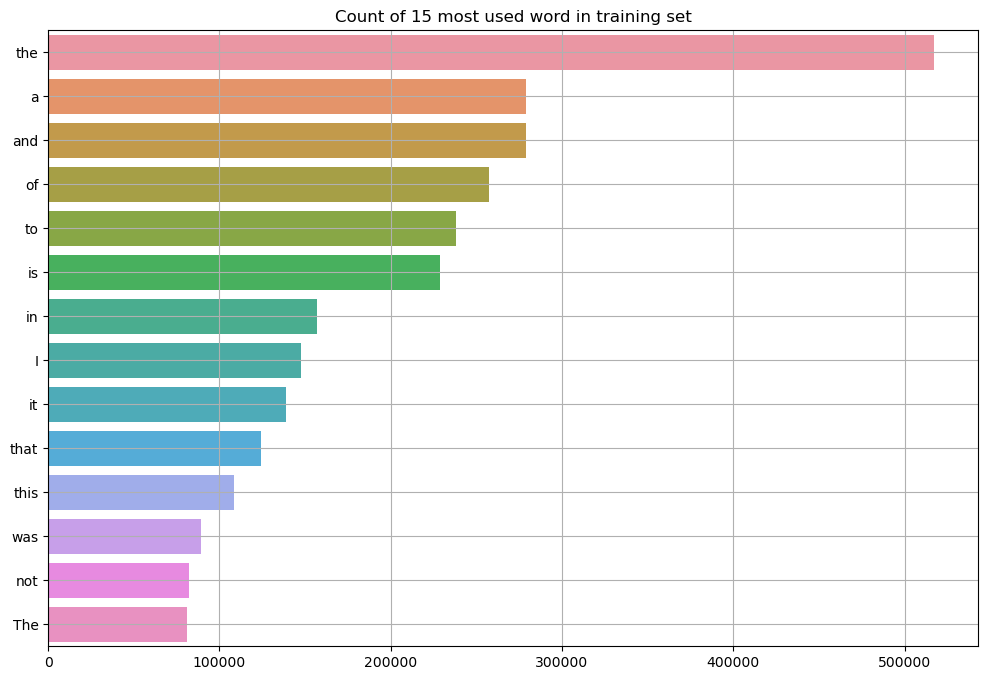

In [26]:
plt.figure(figsize=(12,8))
sns.barplot(x=train_count,y=train_word).set_title('Count of 15 most used word in training set')
plt.grid()

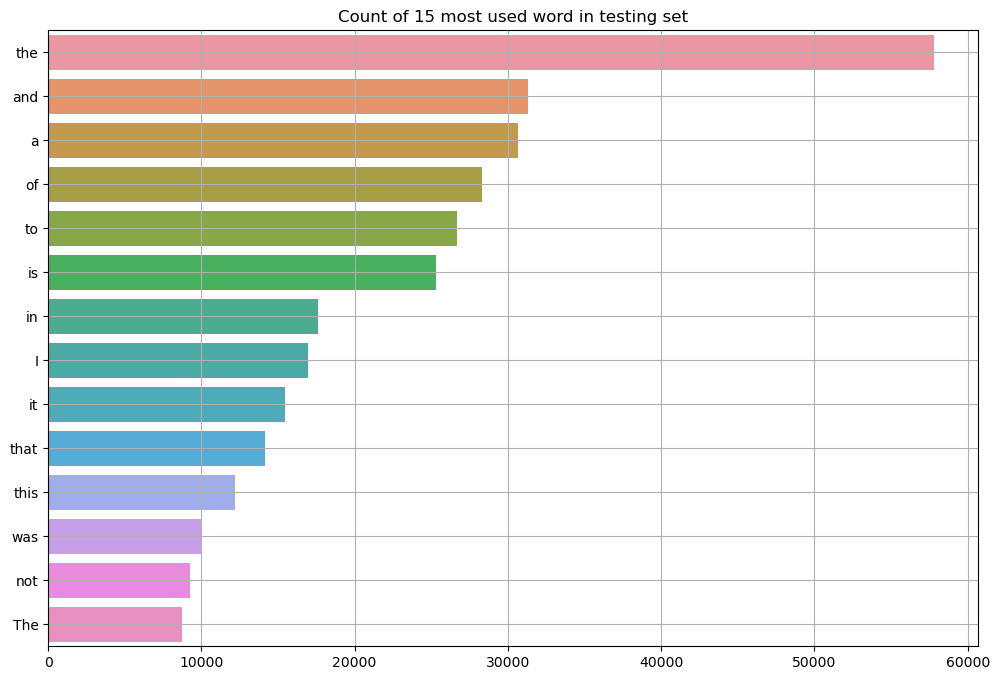

In [27]:
plt.figure(figsize=(12,8))
sns.barplot(x=test_count,y=test_word).set_title('Count of 15 most used word in testing set')
plt.grid()

In [28]:
del glove_embeddings,train_oov,test_oov
gc.collect()

14682

# Model Building

In [29]:
num_words=80000
embeddings=256

In [30]:
tokenizer=Tokenizer(num_words=num_words,oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index
total_vocab=len(word_index)

In [31]:
print("Vocabulary of the dataset is : ",total_vocab)

Vocabulary of the dataset is :  100954


In [32]:
sequences_train=tokenizer.texts_to_sequences(X_train)
sequences_test=tokenizer.texts_to_sequences(X_test)

max_len=max(max([len(x) for x in sequences_train]),max([len(x) for x in sequences_test]))

train_padded=pad_sequences(sequences_train,maxlen=max_len)
test_padded=pad_sequences(sequences_test,maxlen=max_len)

In [33]:
X_train,X_val,Y_train,Y_val=train_test_split(train_padded,Y_train,
                                             test_size=0.05,random_state=10)

In [34]:
model= keras.Sequential()
model.add(Embedding(num_words,embeddings,input_length=max_len))
model.add(Conv1D(256,10,activation='relu'))
model.add(keras.layers.Bidirectional(LSTM(128,return_sequences=True)))
model.add(LSTM(64))
model.add(keras.layers.Dropout(0.4))
model.add(Dense(2,activation='softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2527, 256)         20480000  
                                                                 
 conv1d (Conv1D)             (None, 2518, 256)         655616    
                                                                 
 bidirectional (Bidirectiona  (None, 2518, 256)        394240    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                        

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

In [37]:
es= EarlyStopping(monitor='val_accuracy',
                  patience=2
                 )

checkpoints=ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                            verbose=0,
                            save_best_only=True
                           )

callbacks=[es,checkpoints]

In [38]:
history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=5,callbacks=callbacks)

Epoch 1/5
1336/1336 [==============================] - 572s 413ms/step - loss: 0.4066 - accuracy: 0.8187 - val_loss: 0.3032 - val_accuracy: 0.8684
Epoch 2/5
1336/1336 [==============================] - 491s 367ms/step - loss: 0.2100 - accuracy: 0.9217 - val_loss: 0.2803 - val_accuracy: 0.8956
Epoch 3/5
1336/1336 [==============================] - 467s 350ms/step - loss: 0.1224 - accuracy: 0.9571 - val_loss: 0.2944 - val_accuracy: 0.8907
Epoch 4/5
1336/1336 [==============================] - 478s 358ms/step - loss: 0.0657 - accuracy: 0.9791 - val_loss: 0.3834 - val_accuracy: 0.8964
Epoch 5/5
1336/1336 [==============================] - 460s 344ms/step - loss: 0.0328 - accuracy: 0.9899 - val_loss: 0.4611 - val_accuracy: 0.8858


# Model Evaluation

In [39]:
def plot_graph(history,string):
    
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.title(string+' vs epochs')
    plt.show()

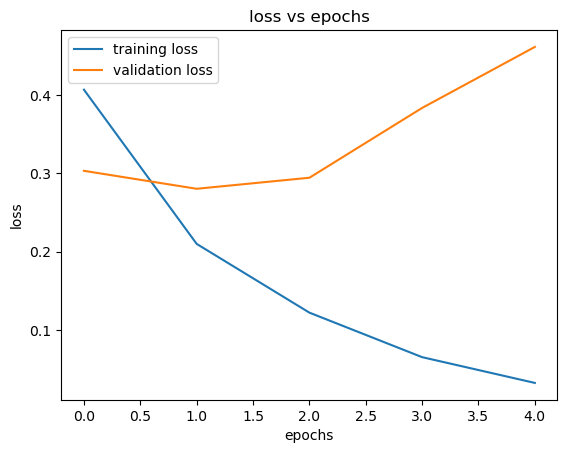

In [40]:
plot_graph(history,'loss')

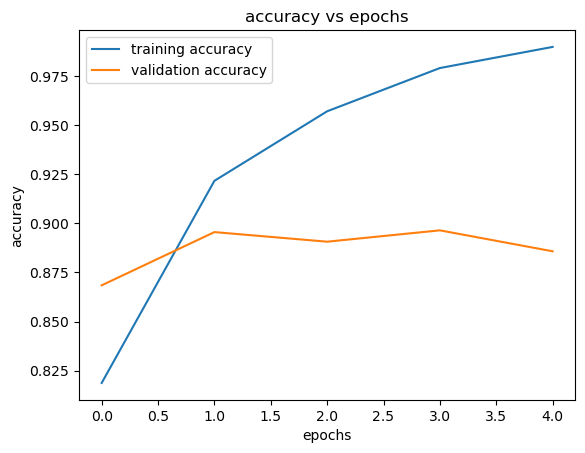

In [41]:
plot_graph(history,'accuracy')

In [42]:
model.save('imdb_model.h5')

In [43]:
print("Model Performance on test set")
result = model.evaluate(test_padded,Y_test)
print(dict(zip(model.metrics_names, result)))

Model Performance on test set
157/157 [==============================] - 18s 115ms/step - loss: 0.4288 - accuracy: 0.8916
{'loss': 0.42878007888793945, 'accuracy': 0.8916000127792358}
